In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
import numpy as np
import pandas as pd
import pywt

alt.data_transformers.enable('default', max_rows=None)
sns.set(color_codes=True)

%matplotlib inline
import sys
sys.path.append("..") # to import from parent directory
from dataset import read_all_data_from_files
from torch.utils.data import DataLoader, Dataset


In [23]:
amplitude, phase, all_labels = read_all_data_from_files(["D:\\Gitdesktop\\KLTN\\pythonFile\\data\\room_1\\1"],)
SUBCARRIES_NUM_TWO_HHZ = 56
SUBCARRIES_NUM_FIVE_HHZ = 114


In [24]:
def calibrate_amplitude(amplitudes, rssi=1):
    """
    Simple amplitude normalization, that could be multiplied by rsii
    ((data - min(data)) / (max(data) - min(data))) * rssi

    :param amplitudes: np.array of shape(data len, num of subcarriers)
    :param rssi: number
    :return: normalized_amplitude: np.array of shape(data len, num of subcarriers)
    """

    amplitudes = np.array(amplitudes)
    return ((amplitudes - np.min(amplitudes)) / (np.max(amplitudes) - np.min(amplitudes))) * rssi

In [25]:
def calibrate_single_phase(phases):
    """
    Calibrate phase data from the single time moment
    Based on:
        https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/sys031fp.pdf
        https://github.com/ermongroup/Wifi_Activity_Recognition/.../phase_calibration.m

    :param phases: phase in the single time moment, np.array of shape(1, num of subcarriers)
    :return: calibrate phase, np.array of shape(1, num of subcarriers)
    """

    phases = np.array(phases)
    difference = 0

    calibrated_phase, calibrated_phase_final = np.zeros_like(phases), np.zeros_like(phases)
    calibrated_phase[0] = phases[0]

    phases_len = phases.shape[0]

    for i in range(1, phases_len):
        temp = phases[i] - phases[i - 1]

        if abs(temp) > np.pi:
            difference = difference + 1 * np.sign(temp)

        calibrated_phase[i] = phases[i] - difference * 2 * np.pi

    k = (calibrated_phase[-1] - calibrated_phase[0]) / (phases_len - 1)
    b = np.mean(calibrated_phase)

    for i in range(phases_len):
        calibrated_phase_final[i] = calibrated_phase[i] - k * i - b

    return calibrated_phase_final


def calibrate_phase(phases):
    """
    Calibrate phase data based on the following method:
        https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/sys031fp.pdf
        https://github.com/ermongroup/Wifi_Activity_Recognition/.../phase_calibration.m

    :param phases: np.array of shape(data len, num of subcarries)
    :return: calibrated phases: np.array of shape(data len, num of subcarriers)
    """

    calibrated_phases = np.zeros_like(phases)

    for i in range(phases.shape[0]):
        calibrated_phases[i] = calibrate_single_phase(np.unwrap(phases[i]))

    return calibrated_phases

In [26]:
c_amplitude = calibrate_amplitude(amplitude)
c_phase = calibrate_phase(phase)

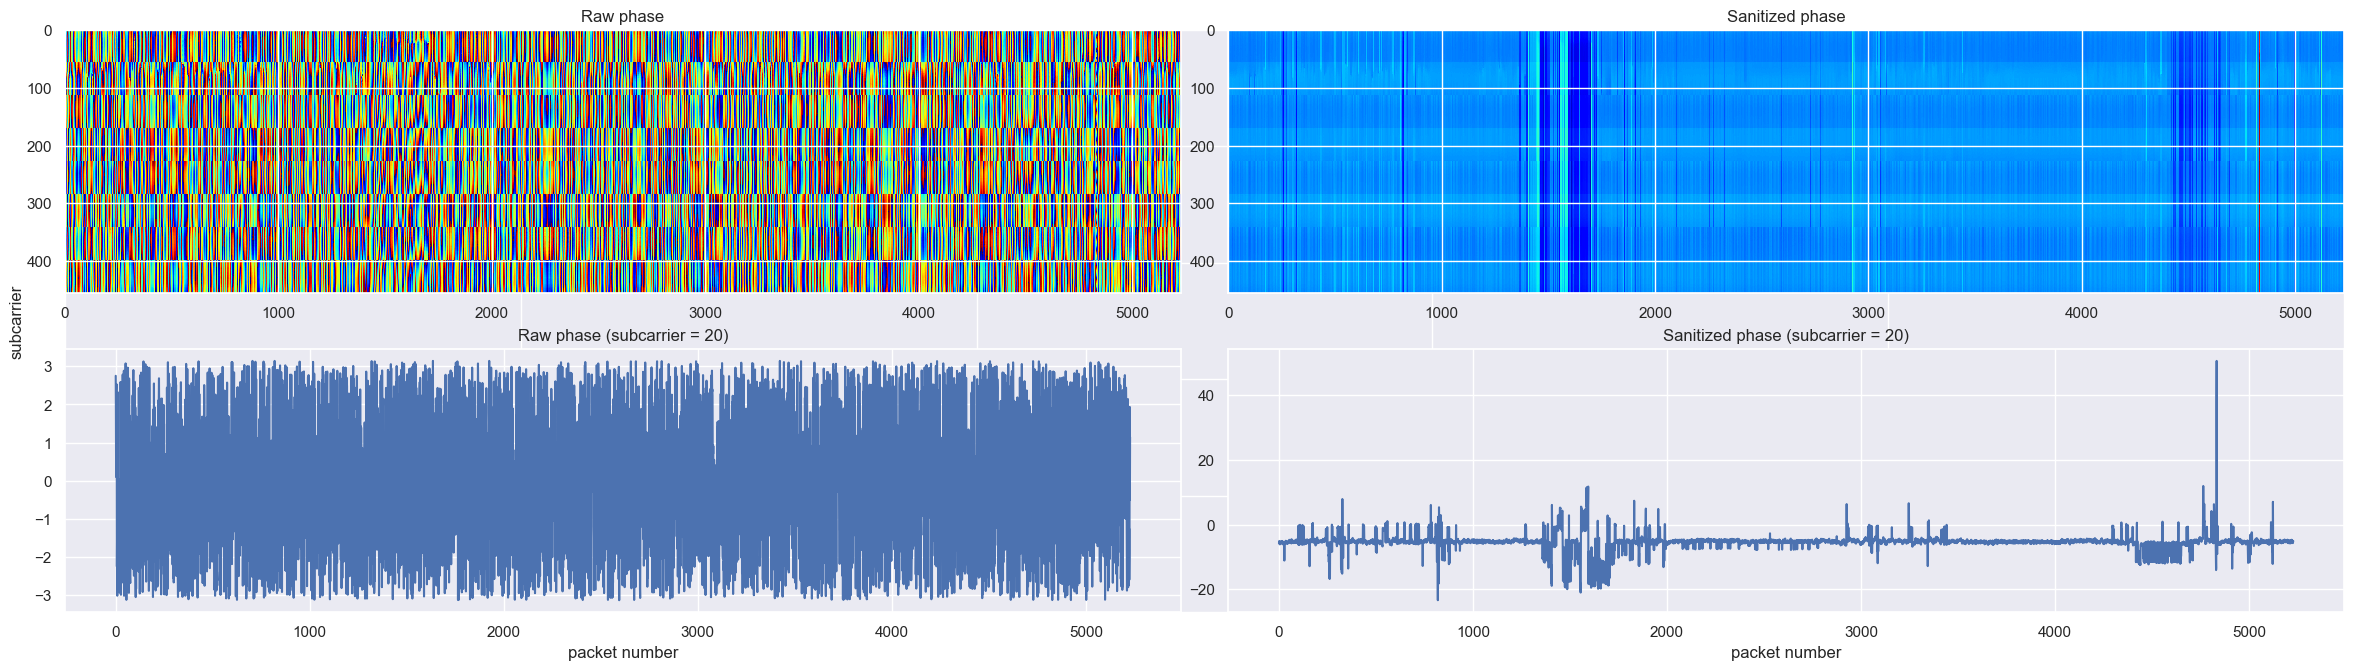

In [27]:

fig = plt.figure(figsize = (24, 7))
ax = fig.add_subplot(111)

ax1 = plt.subplot(221)
plt.imshow((phase).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Raw phase")
#plt.colorbar()

ax2 = plt.subplot(222)
plt.imshow((c_phase).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("Sanitized phase")
# plt.colorbar()

ax3 = fig.add_subplot(223)
plt.plot((phase)[:, 20])
ax3.set_title("Raw phase (subcarrier = 20)")

ax4 = fig.add_subplot(224)
plt.plot((c_phase)[:, 20])
ax4.set_title("Sanitized phase (subcarrier = 20)")

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax.set_ylabel('subcarrier')
ax3.set_xlabel('packet number')
ax4.set_xlabel('packet number')

# fig.suptitle('WiFi 2.4 vs 5 HHz frequency for 1-to-1 antenna pair', fontsize=23)
fig.tight_layout(pad=0.5)

plt.show()

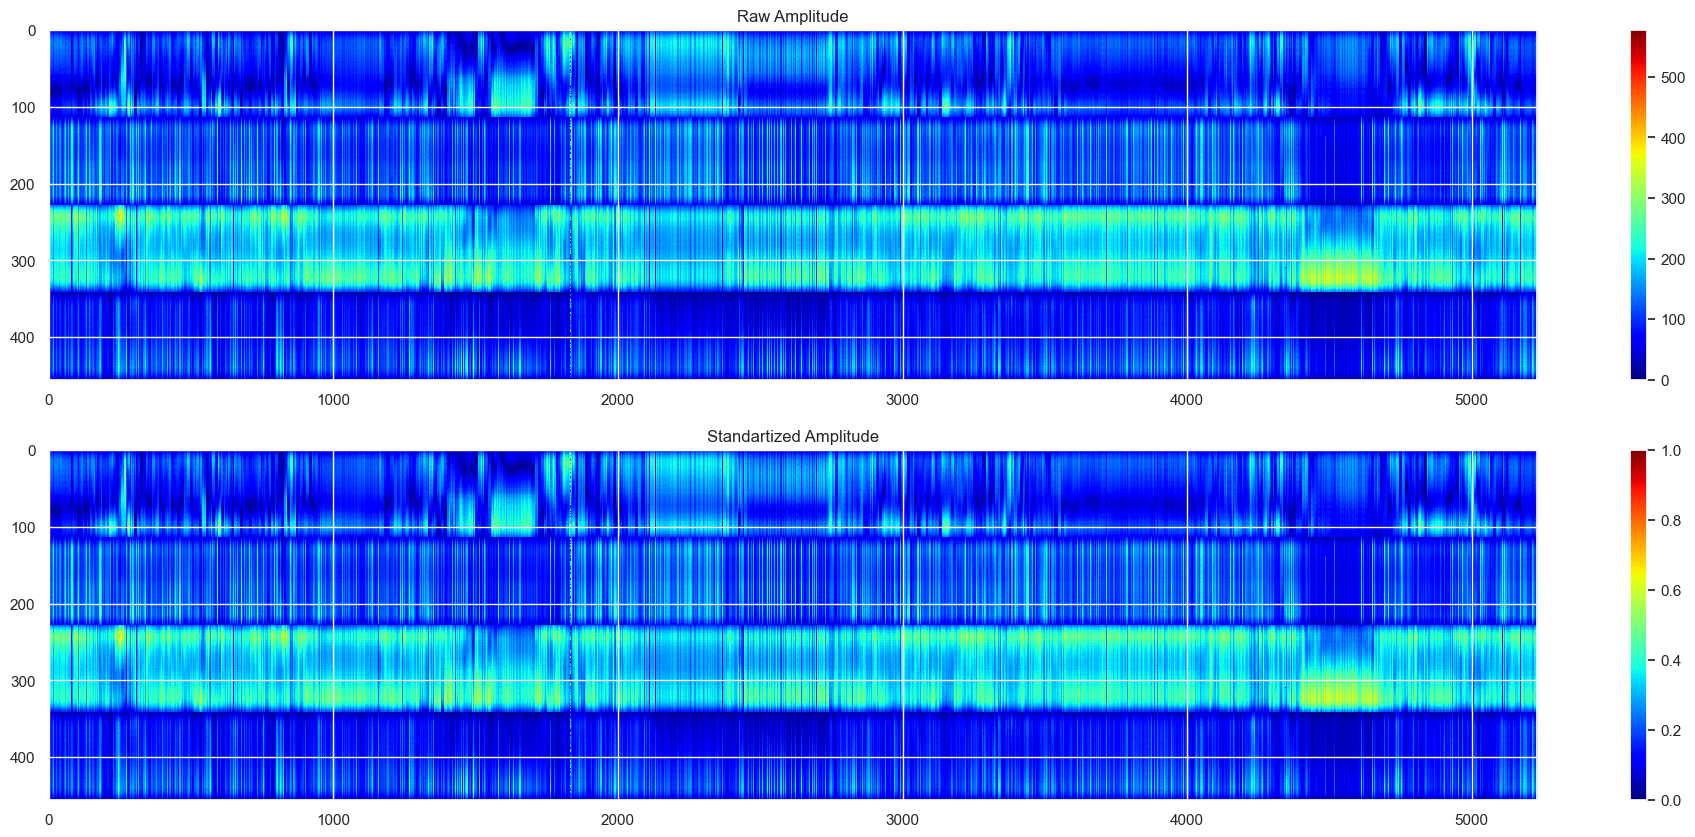

In [28]:
fig = plt.figure(figsize = (24,10))


ax1 = plt.subplot(211)
plt.imshow((amplitude).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Raw Amplitude")
plt.colorbar()

ax2 = plt.subplot(212)
plt.imshow((c_amplitude).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("Standartized Amplitude")
plt.colorbar()

plt.show()

In [29]:
def hampel(vals_orig, k=7, t0=3):
    # Make copy so original not edited
    vals = pd.Series(vals_orig.copy())

    # Hampel Filter
    L = 1.4826

    rolling_median = vals.rolling(k).median()
    difference = np.abs(rolling_median - vals)
    median_abs_deviation = difference.rolling(k).median()
    threshold = t0 * L * median_abs_deviation
    outlier_idx = difference > threshold
    vals[outlier_idx] = rolling_median

    # print("vals: ", vals.shape)
    return vals.to_numpy()


In [30]:
h_amplitude = np.zeros_like(c_amplitude)
data_len = c_phase.shape[0]
for i in range(c_phase.shape[1]):
    h_amplitude[:data_len, i] = hampel(c_amplitude[:, i])[:data_len]

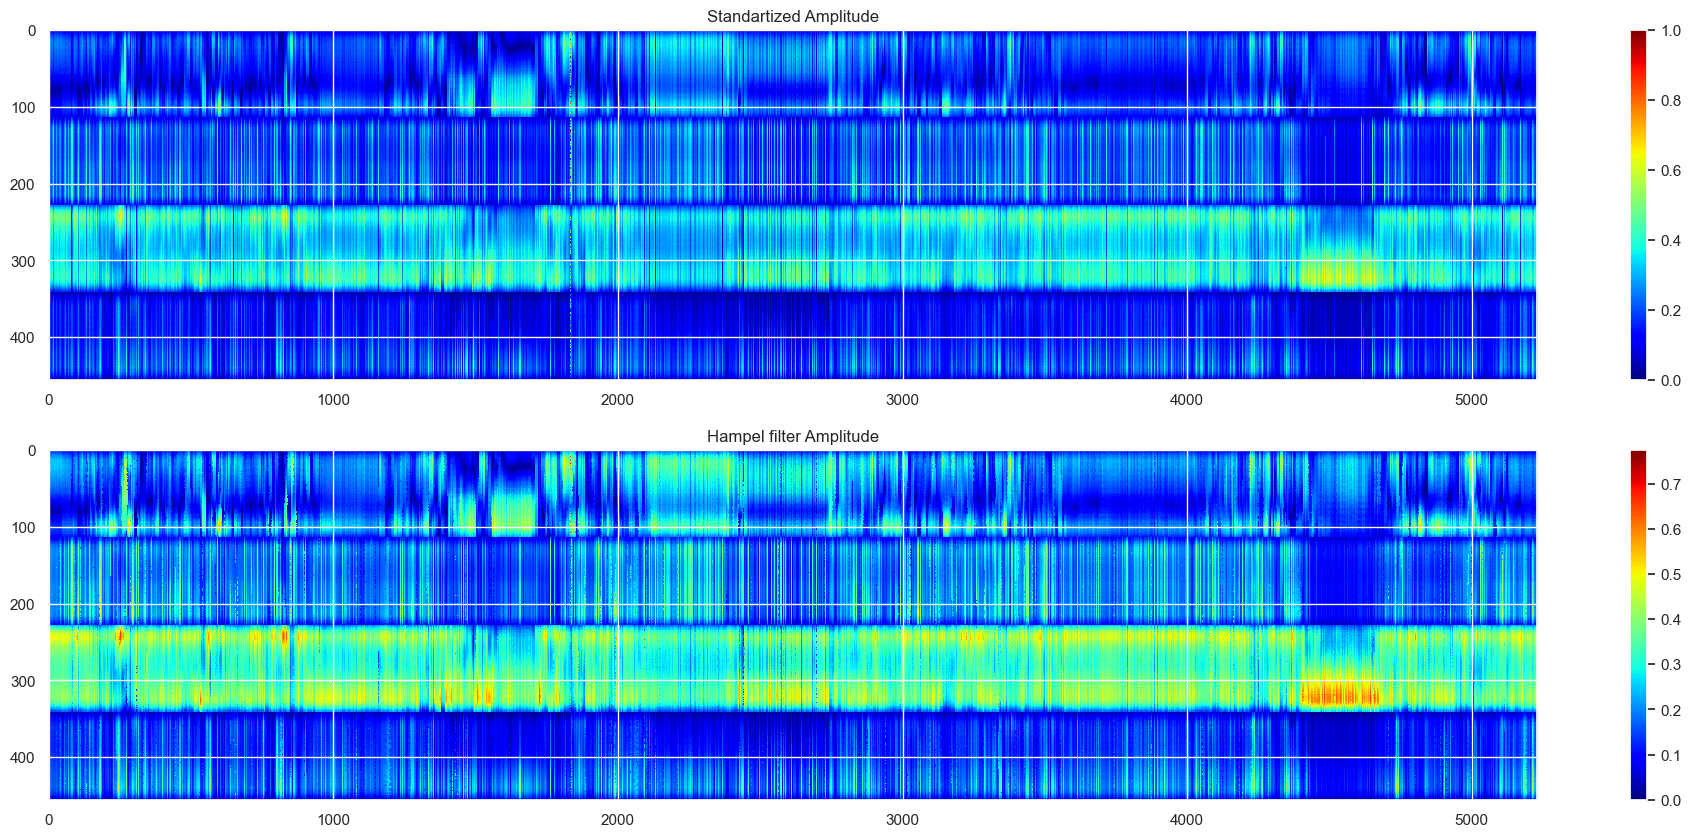

In [31]:
fig = plt.figure(figsize = (24,10))
ax1 = plt.subplot(211)
plt.imshow((c_amplitude).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Standartized Amplitude")
plt.colorbar()

ax2 = plt.subplot(212)
plt.imshow((h_amplitude).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("Hampel filter Amplitude")
plt.colorbar()

plt.show()

In [32]:
def dwn_noise(vals):
    data = vals.copy()
    threshold = 0.06  # Threshold for filtering

    w = pywt.Wavelet('sym5')
    maxlev = pywt.dwt_max_level(data.shape[0], w.dec_len)

    coeffs = pywt.wavedec(data, 'sym5', level=maxlev)

    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold * max(coeffs[i]))

    datarec = pywt.waverec(coeffs, 'sym5')

    return datarec

In [33]:
f_amplitude = np.zeros_like(h_amplitude)
data_len = c_phase.shape[0]
for i in range(c_phase.shape[1]):
    # self.phases[:data_len, i] = dwn_noise(hampel(self.phases[:, i]))[:data_len]
    f_amplitude[:data_len, i] = dwn_noise(h_amplitude[:, i])[:data_len]


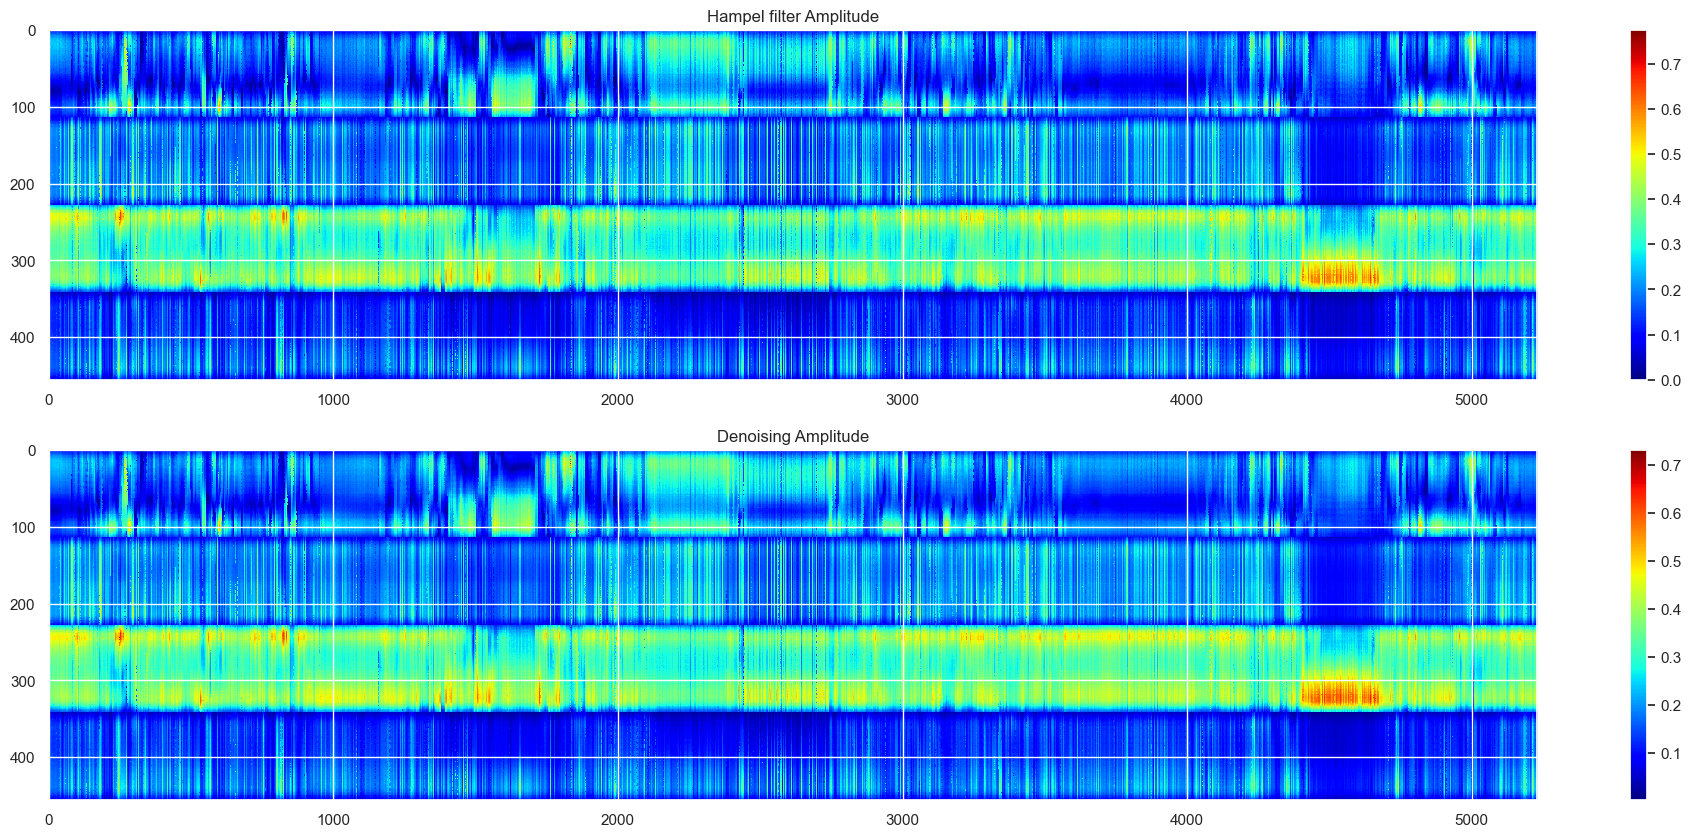

In [34]:
fig = plt.figure(figsize = (24,10))
ax1 = plt.subplot(211)
plt.imshow((h_amplitude).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Hampel filter Amplitude")
plt.colorbar()

ax2 = plt.subplot(212)
plt.imshow((f_amplitude).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("Denoising Amplitude")
plt.colorbar()

plt.show()

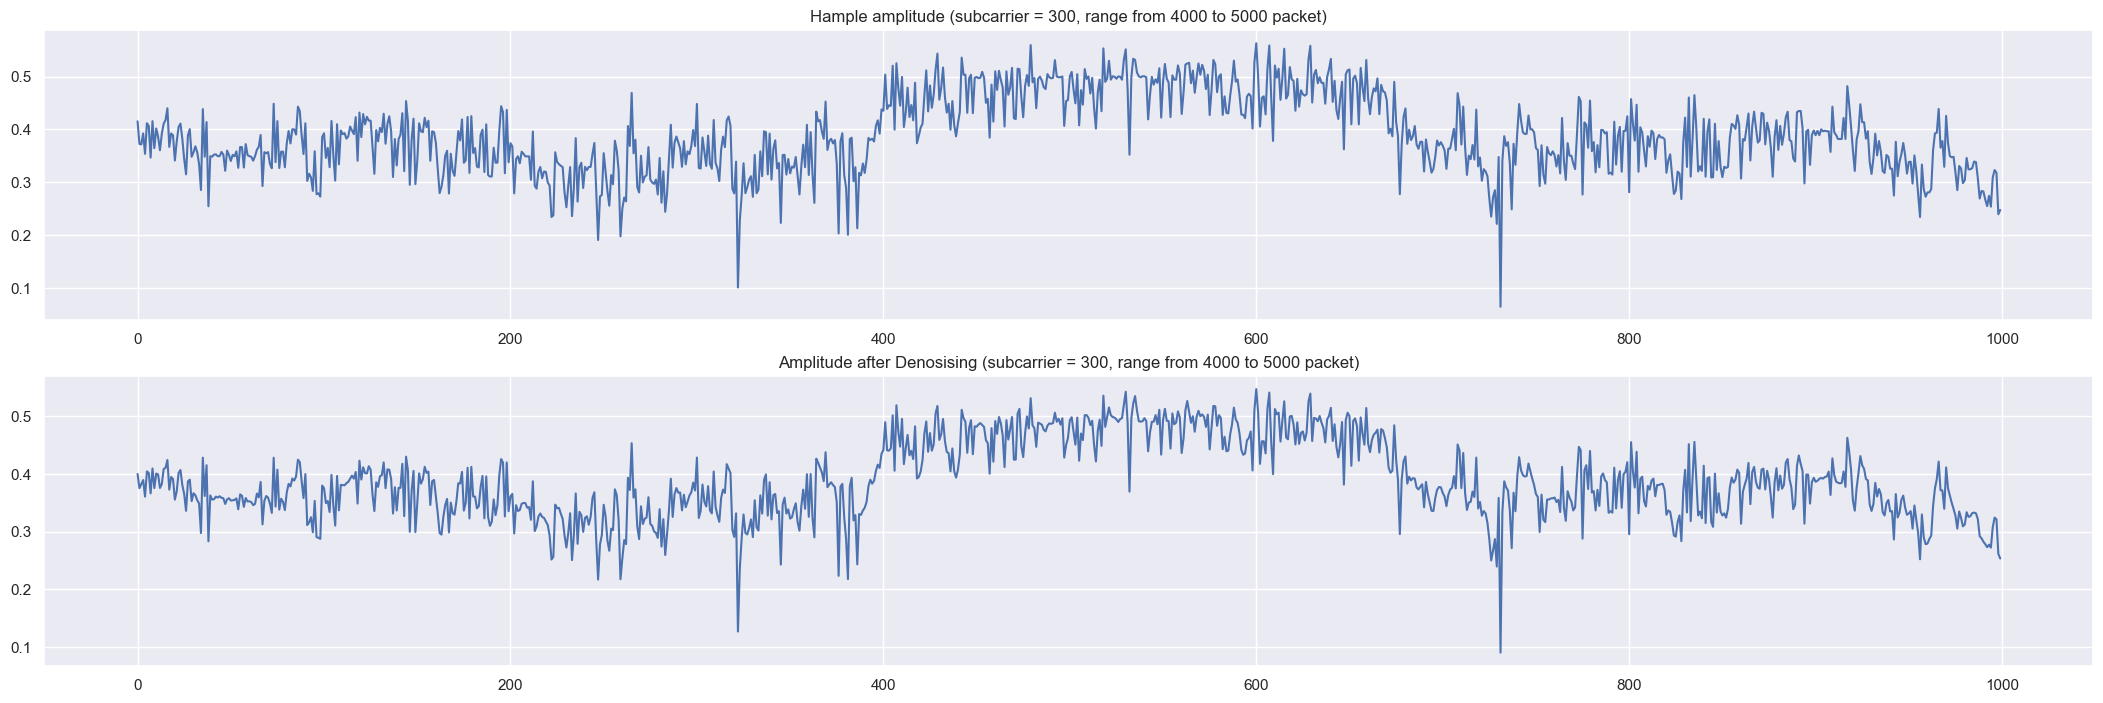

In [35]:
fig = plt.figure(figsize = (21, 7))

ax1 = fig.add_subplot(211)
plt.plot((h_amplitude)[4000:5000, 300])
ax1.set_title("Hample amplitude (subcarrier = 300, range from 4000 to 5000 packet)")

ax2 = fig.add_subplot(212)
plt.plot(f_amplitude[4000:5000, 300])
ax2.set_title("Amplitude after Denosising (subcarrier = 300, range from 4000 to 5000 packet)")

fig.tight_layout(pad=0.5)

plt.show()

In [36]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=3)
amplitudes_pca = []
for i in range(4):
    amplitudes_pca.append(
        pca.fit_transform(
            f_amplitude[:, i*SUBCARRIES_NUM_FIVE_HHZ:(i+1)*SUBCARRIES_NUM_FIVE_HHZ]
        )
    )
amplitudes_pca = np.array(amplitudes_pca)
amplitudes_pca = amplitudes_pca.reshape(
    (
        amplitudes_pca.shape[1],
        amplitudes_pca.shape[0] * amplitudes_pca.shape[2],
    )
)

In [37]:
print(c_amplitude.shape)
print(h_amplitude.shape)
print(f_amplitude.shape)
print(amplitudes_pca.shape)


(5229, 456)
(5229, 456)
(5229, 456)
(5229, 12)


Text(0.5, 1.0, 'PCA4')

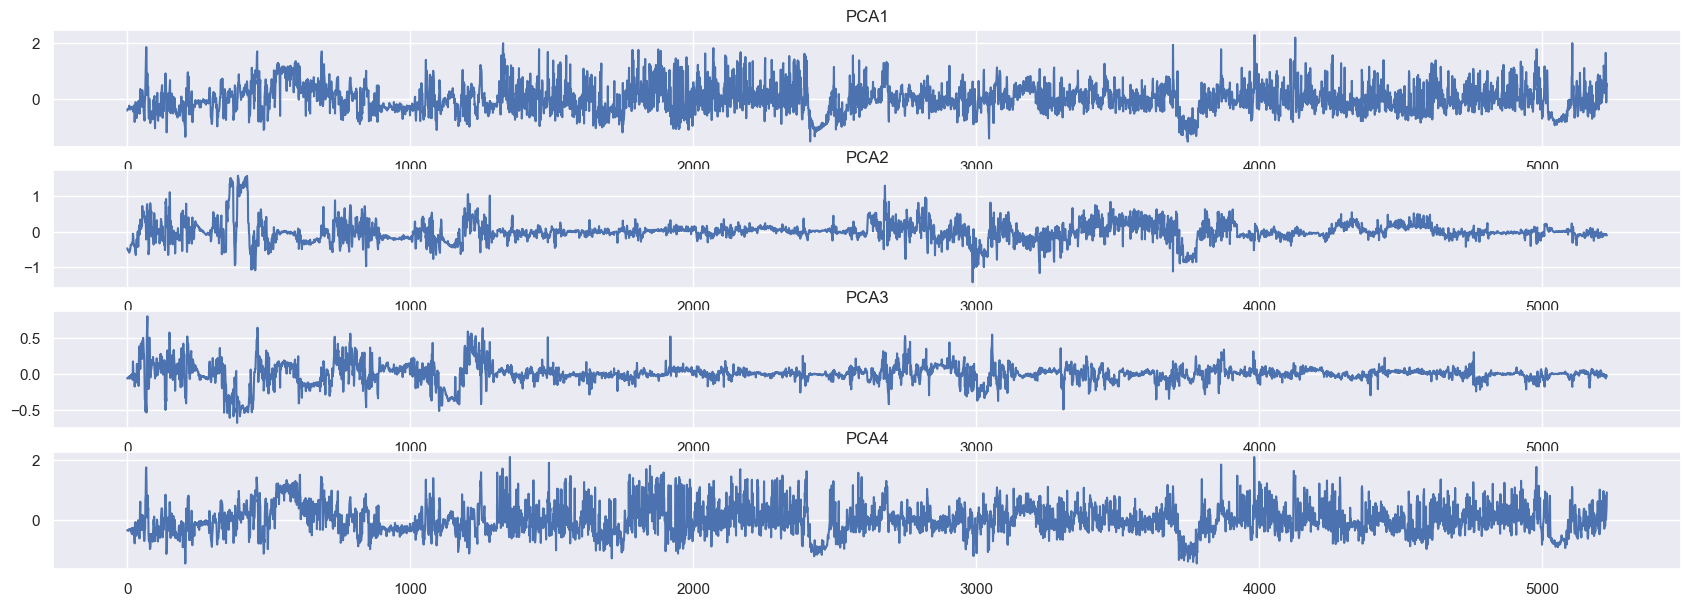

In [38]:
fig = plt.figure(figsize = (21, 7))

ax1 = fig.add_subplot(411)
plt.plot(amplitudes_pca.T[0])
ax1.set_title("PCA1")

ax2 = fig.add_subplot(412)
plt.plot(amplitudes_pca.T[1])
ax2.set_title("PCA2")

ax3 = fig.add_subplot(413)
plt.plot(amplitudes_pca.T[2])
ax3.set_title("PCA3")

ax4 = fig.add_subplot(414)
plt.plot(amplitudes_pca.T[3])
ax4.set_title("PCA4")

In [39]:
class DLDataset(Dataset):
    """CSI Dataset."""

    def __init__(self,f_amplitude ,amplitudes_pca, c_phase, all_labels, window_size=32, step=1):
        from sklearn import decomposition

        self.amplitudes, self.phases = f_amplitude, c_phase
        self.labels = all_labels
        self.amplitudes_pca = amplitudes_pca
        self.label_keys = list(set(self.labels))
        self.class_to_idx = {
            "standing": 0,
            "walking": 1,
            "get_down": 2,
            "sitting": 3,
            "get_up": 4,
            "lying": 5,
            "no_person": 6,
        }
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}

        self.window = window_size
        if window_size == -1:
            self.window = self.labels.shape[0] - 1

        self.step = step

    def __getitem__(self, idx):
        if self.window == 0:
            return (
                np.append(self.amplitudes[idx], self.phases[idx]),
                self.class_to_idx[self.labels[idx + self.window - 1]],
            )

        idx = idx * self.step
        all_xs = []

        for index in range(idx, idx + self.window):
            all_xs.append(np.append(self.amplitudes[index], self.amplitudes_pca[index]))

        return np.array(all_xs), self.class_to_idx[self.labels[idx + self.window - 1]]

    def __len__(self):
        return int((self.labels.shape[0] - self.window) // self.step) + 1

In [40]:

train_dataset = DLDataset(
    f_amplitude, amplitudes_pca, c_phase, all_labels,
    1024,
    8,)

val_dataset = train_dataset

trn_dl = DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=0
)
val_dl = DataLoader(
    val_dataset, batch_size=4, shuffle=False, num_workers=0
)

In [41]:
for i in trn_dl:
    print(i)
    break

[tensor([[[ 1.2748e-01,  1.4140e-01,  1.5220e-01,  ...,  4.6106e-01,
           4.6812e-02, -1.3906e-01],
         [ 1.1966e-01,  1.3508e-01,  1.4601e-01,  ..., -3.6967e-01,
          -9.0522e-02,  2.6495e-02],
         [ 1.1625e-01,  1.3128e-01,  1.4303e-01,  ..., -7.5693e-01,
           8.2825e-02,  4.6479e-03],
         ...,
         [ 1.1682e-01,  1.1033e-01,  1.1684e-01,  ...,  1.0144e+00,
          -2.5938e-01,  1.1330e-02],
         [ 1.1772e-01,  1.1621e-01,  1.2691e-01,  ...,  2.0016e+00,
          -1.0485e-01,  3.6652e-02],
         [ 1.1722e-01,  1.1813e-01,  1.2414e-01,  ...,  1.2237e+00,
          -1.7887e-01,  4.1437e-02]],

        [[ 2.4098e-02,  2.7695e-02,  3.1374e-02,  ..., -5.7274e-01,
          -9.1856e-02,  6.5758e-02],
         [ 2.2954e-02,  2.4345e-02,  3.0440e-02,  ..., -5.1055e-01,
          -1.6049e-01,  2.2250e-02],
         [ 2.2459e-02,  2.1886e-02,  2.6558e-02,  ..., -5.4179e-01,
          -1.9498e-01,  6.6985e-02],
         ...,
         [ 1.9532e-01,  